In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os

def run(Lx,M,noqueue=False):
    if noqueue:
        os.system("python RNN-QSR.py %d %.3f nq"%(Lx,M))
    else:
        os.system("python RNN-QSR.py %d %.3f"%(Lx,M))

def show(Lx,Ly,M,mydir=None,noqueue=False):
    
    exact_energy = {16:-0.4534,36:-0.4221,64:-0.40522,144:-0.38852,256:-0.38052,576:-0.36,1024:-0.34}[Lx*Ly]
    if type(mydir)==type(None):
        bsize=512
        BlockNum=(Lx*Ly)//8
        BbyL=bsize//BlockNum
        bsize=BbyL*BlockNum
        print(bsize,BlockNum,BbyL,Lx*Ly)
        if noqueue:
            mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(Lx,Ly,M,BbyL,BbyL)
        else:
            mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(Lx,Ly,M,bsize,BbyL)
    
    DEBUG = np.load(mydir+"/DEBUG.npy")
    
    fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
    plt.plot(DEBUG[:,5]/Lx/Ly-exact_energy,alpha=0.1,color='b',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
    plt.plot(DEBUG[:,1]/Lx/Ly-exact_energy,'ro',ms=0.5,lw=0.0,label="RNN Train")
    plt.yscale("log")
    plt.ylim(1e-5,5)
    plt.xlabel("Step",fontsize=15)
    plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
    plt.legend(loc="best")
    plt.show()
    
    fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
    plt.plot(DEBUG[:,5]/Lx/Ly,'bo',markersize=0.5,linewidth=0.0,markevery=5,label="RNN Sample")
    plt.plot(DEBUG[:,1]/Lx/Ly,'ro',markersize=0.5,linewidth=0.0,markevery=5,label="RNN Train")
    plt.plot([0,len(DEBUG)],[exact_energy,exact_energy],'k--')
    plt.ylim(max(min(DEBUG[:,1])-0.3,-1),0.5)
    plt.xlabel("Step",fontsize=15)
    plt.ylabel("$\\langle H \\rangle$",fontsize=20)
    plt.legend(loc="best")
    plt.show()
    
    fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
    plt.plot(DEBUG[:,5]/Lx/Ly-exact_energy,'bo',ms=2,label="Sample")
    plt.plot(DEBUG[:,3]/Lx/Ly-exact_energy,'ro',ms=1,lw=1,label="Corrected (Training)")
    plt.yscale("log")
    plt.xlabel("Step",fontsize=15)
    plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
    plt.legend(loc="best")
    plt.show()
    print("TIME: %.0fs"%DEBUG[-1][-1])
    print("Last Corrected %.4f"% (DEBUG[-1,3]/Lx/Ly))

In [2]:
#show(32,32,0.99,mydir="out/stable")

# 4x4 Queue

In [3]:
run(4,0.99)

512 2 256 16


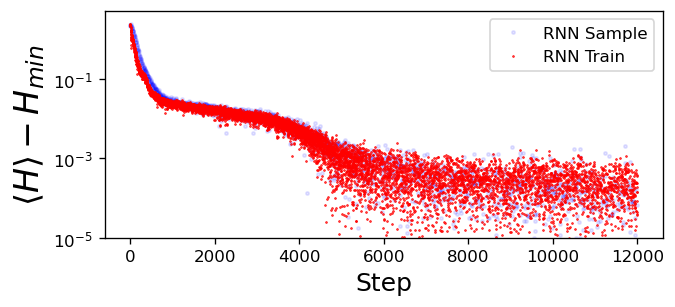

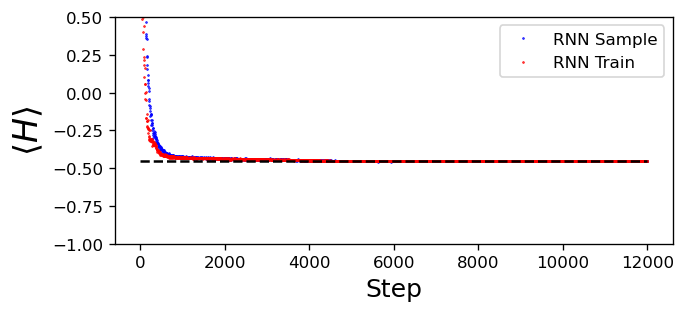

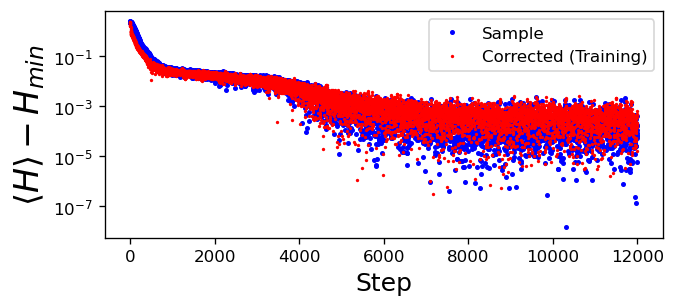

TIME: 136s
Last Corrected -0.4533


In [29]:
show(4,4,0.99)

# 6x6 Queue


In [5]:
run(6,0.99)

512 4 128 36


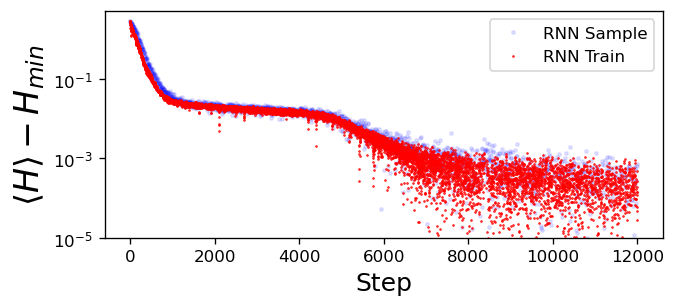

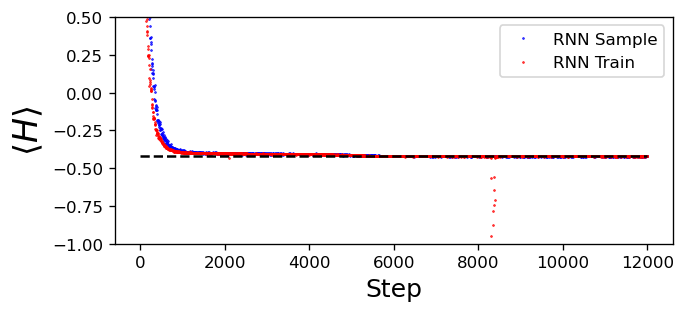

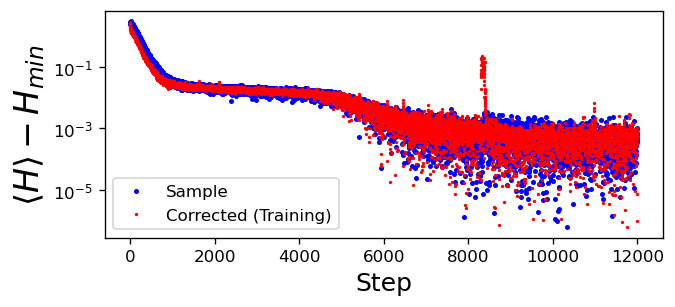

TIME: 266s
Last Corrected -0.4221


In [30]:
show(6,6,0.99)

# 8x8 Queue


In [7]:
run(8,0.99)

512 8 64 64


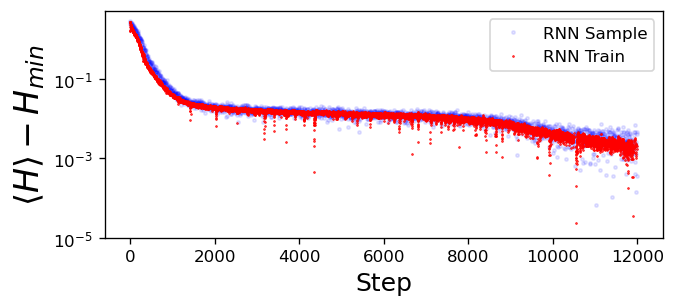

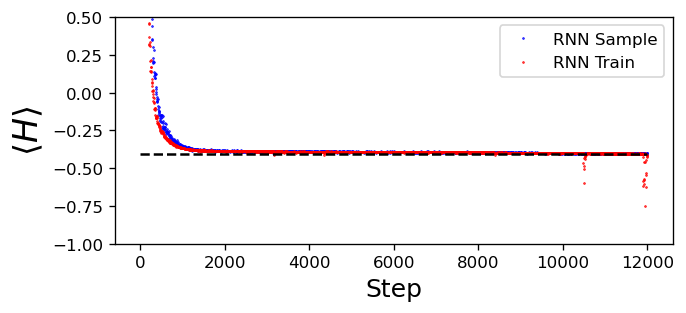

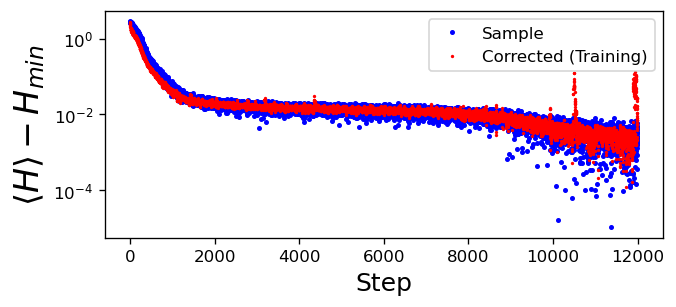

TIME: 428s
Last Corrected -0.4027


In [8]:
show(8,8,0.99)

# 12x12 Queue


In [9]:
run(12,0.99)

504 18 28 144


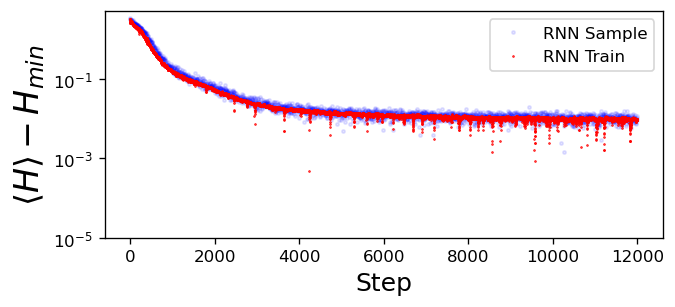

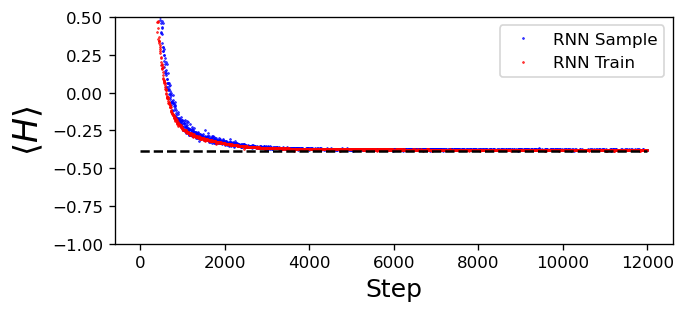

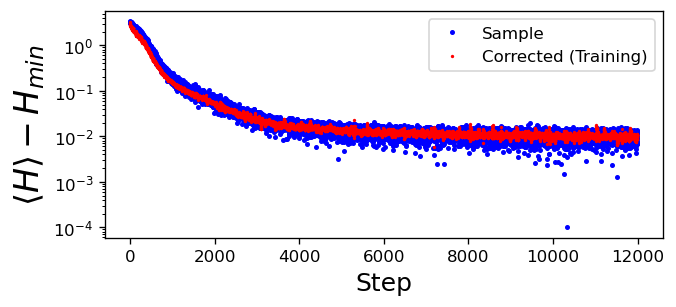

TIME: 906s
Last Corrected -0.3786


In [10]:
show(12,12,0.99)

# 16x16 Queue


In [11]:
run(16,0.99)

512 32 16 256


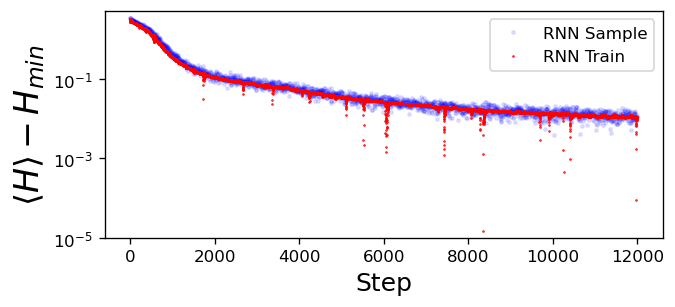

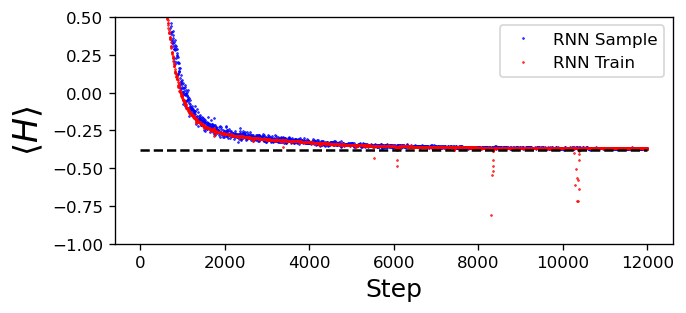

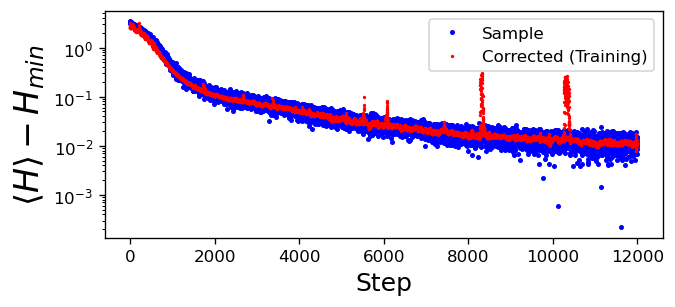

TIME: 1621s
Last Corrected -0.3681


In [12]:
show(16,16,0.99)

# No momentum:

512 2 256 16


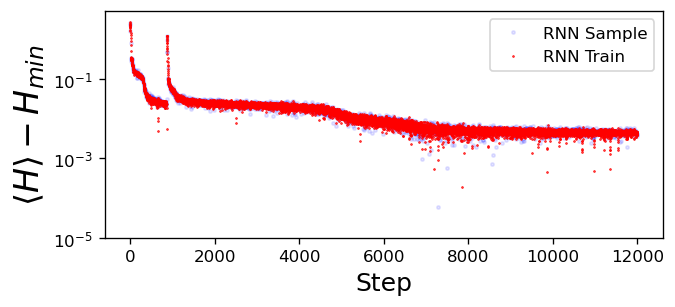

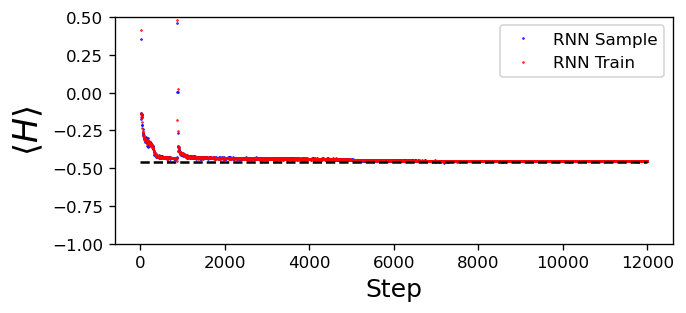

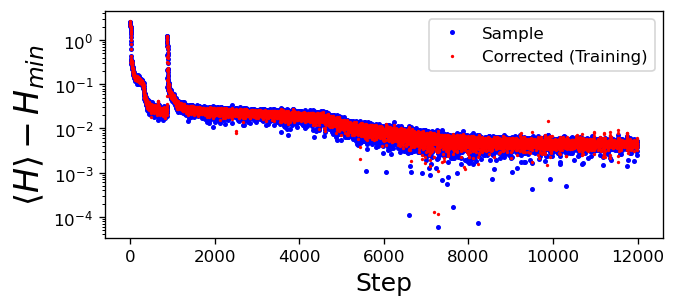

TIME: 137s
Last Corrected -0.4527
512 4 128 36


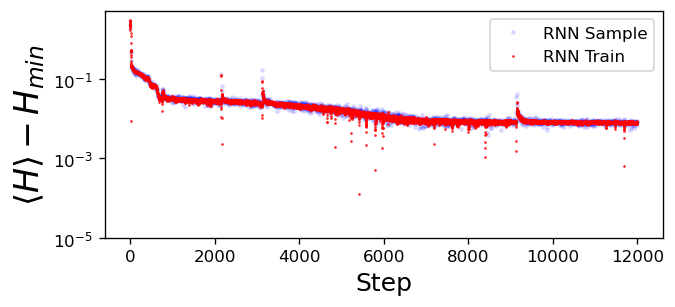

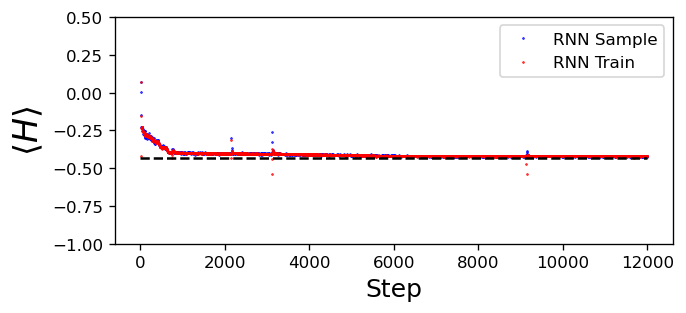

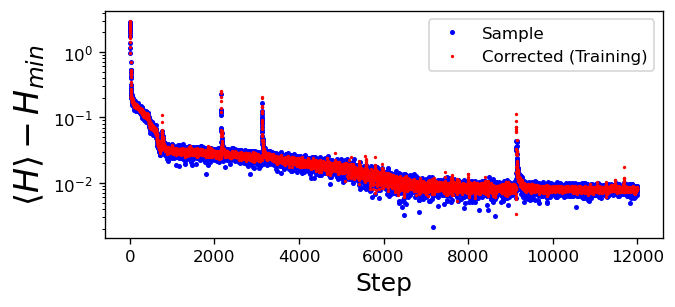

TIME: 276s
Last Corrected -0.4214
512 8 64 64


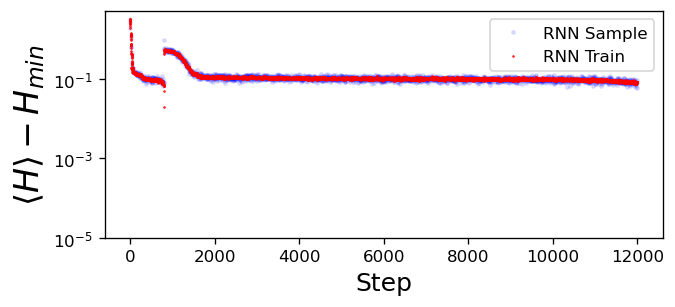

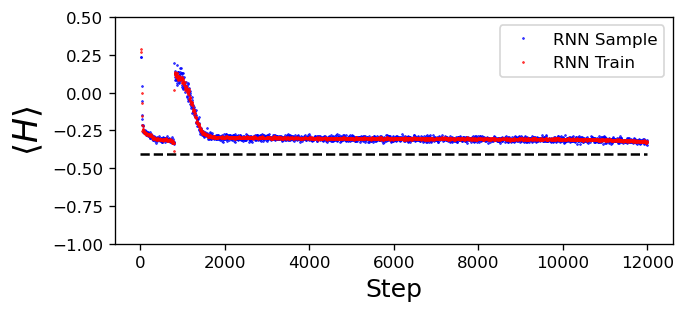

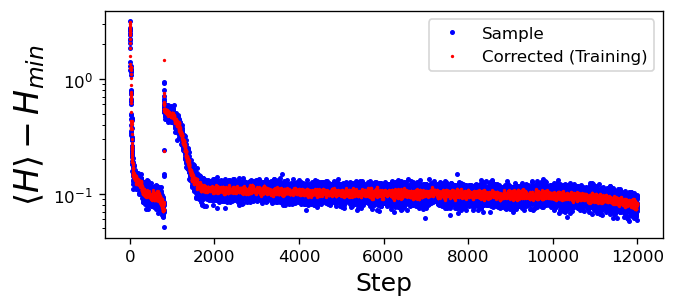

TIME: 429s
Last Corrected -0.3250
504 18 28 144


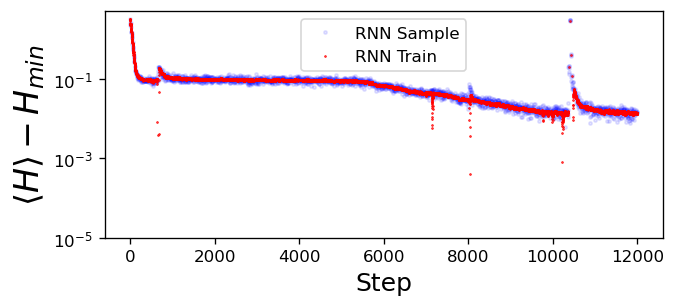

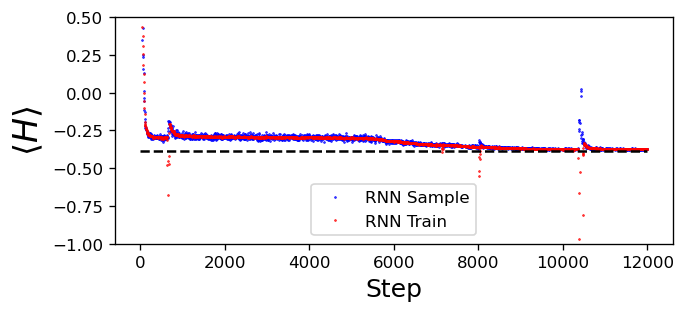

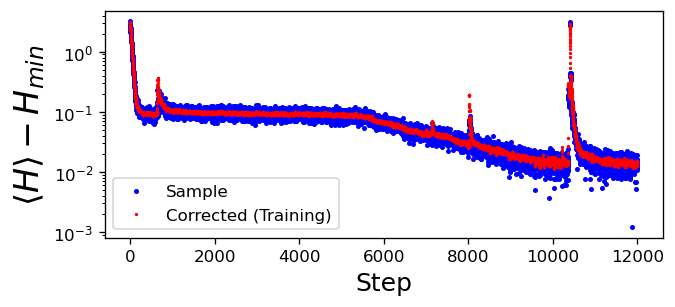

TIME: 909s
Last Corrected -0.3739
512 32 16 256


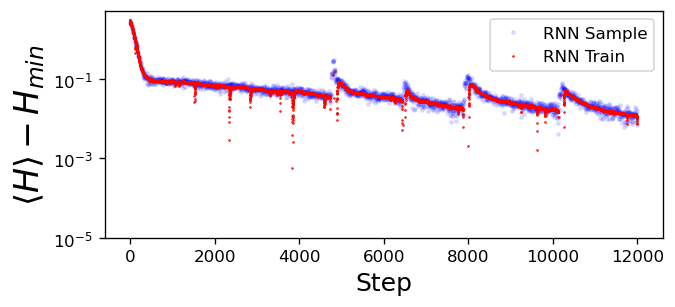

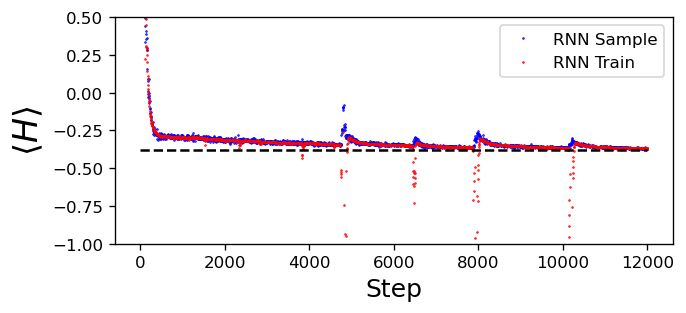

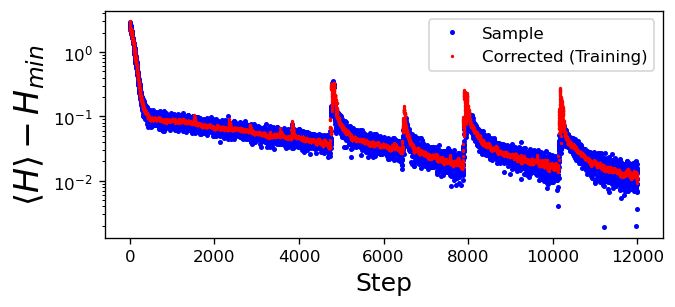

TIME: 1595s
Last Corrected -0.3702


In [13]:
run(4,0.0)
run(6,0.0)
run(8,0.0)
run(12,0.0)
run(16,0.0)
show(4,4,0.0)
show(6,6,0.0)
show(8,8,0.0)
show(12,12,0.0)
show(16,16,0.0)

# No Queue



512 2 256 16


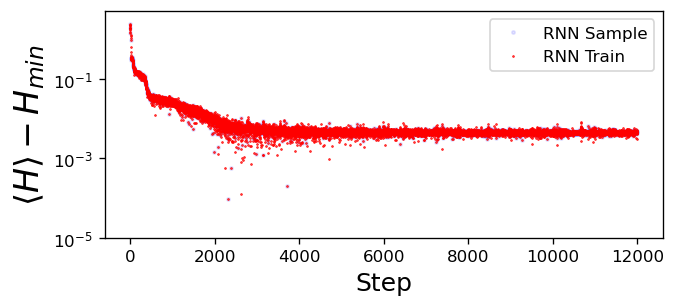

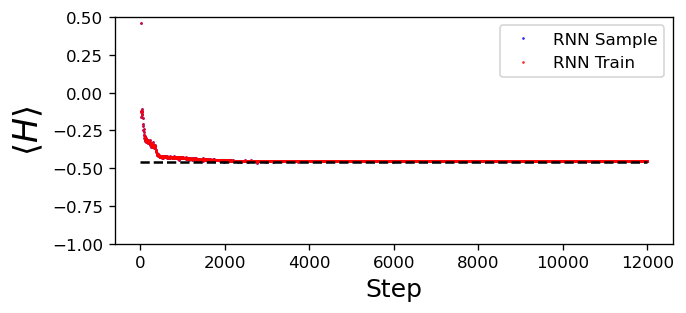

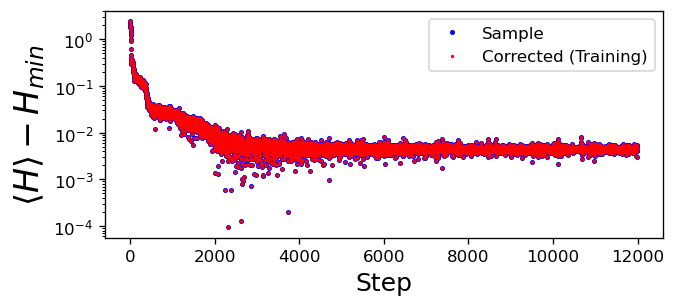

TIME: 137s
Last Corrected -0.4533
512 4 128 36


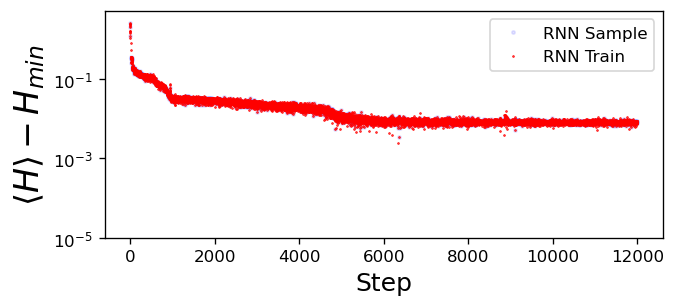

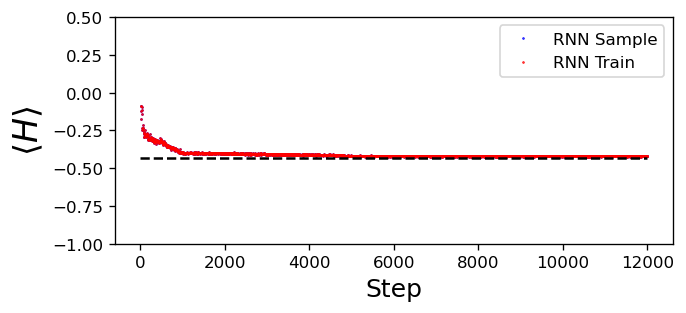

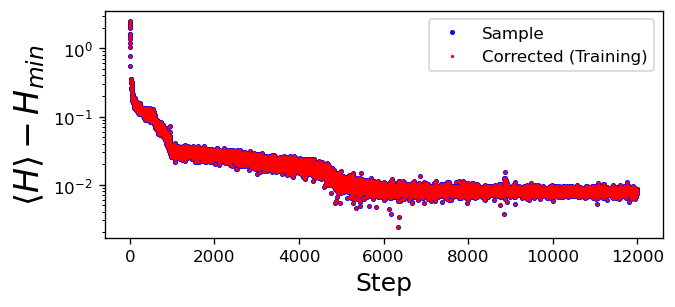

TIME: 266s
Last Corrected -0.4222
512 8 64 64


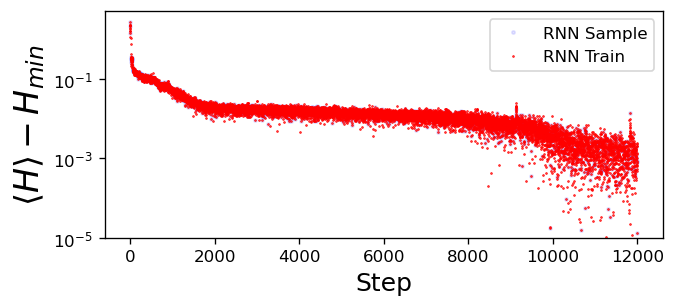

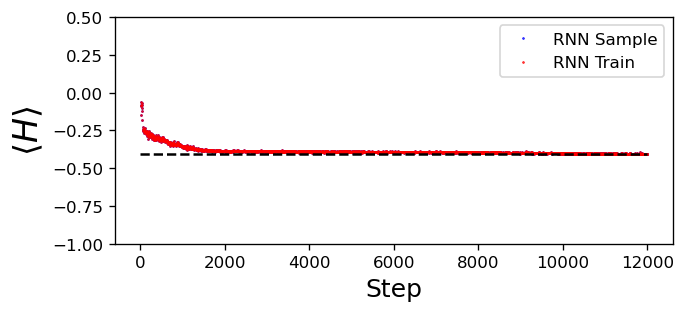

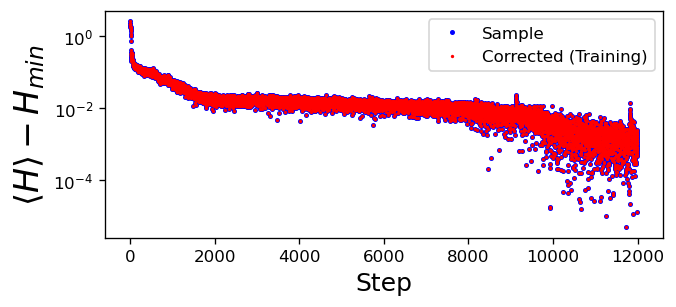

TIME: 430s
Last Corrected -0.4038
504 18 28 144


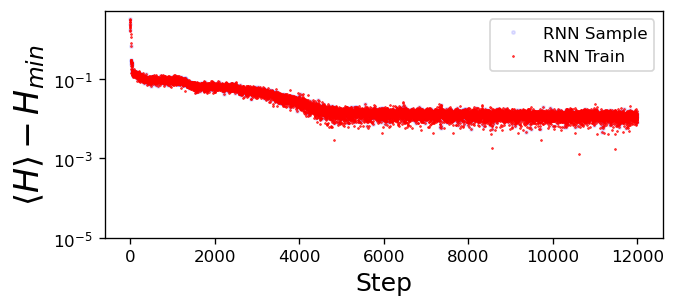

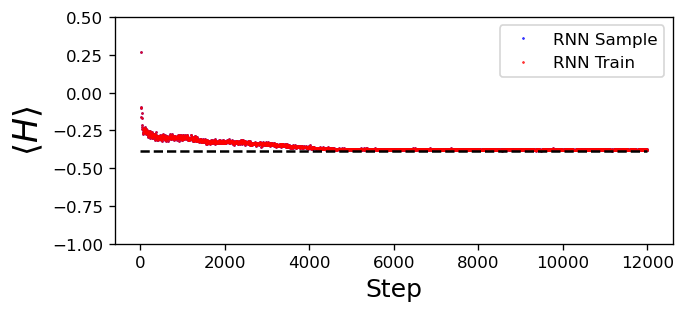

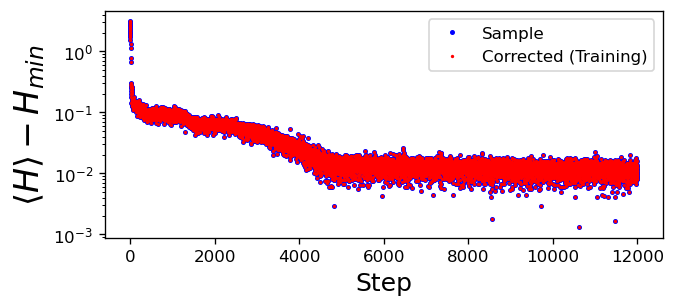

TIME: 854s
Last Corrected -0.3795
512 32 16 256


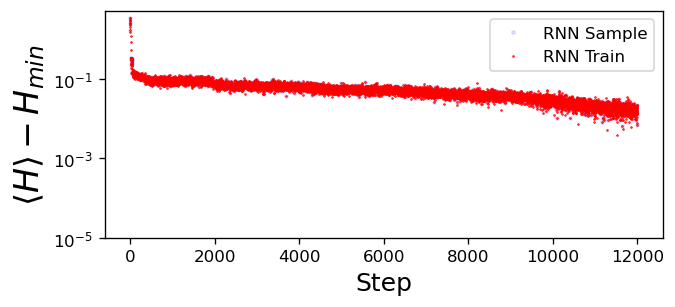

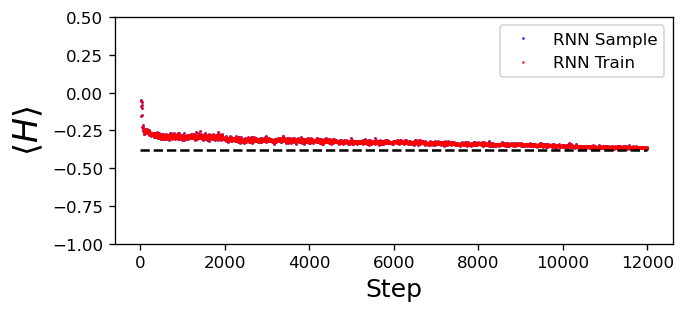

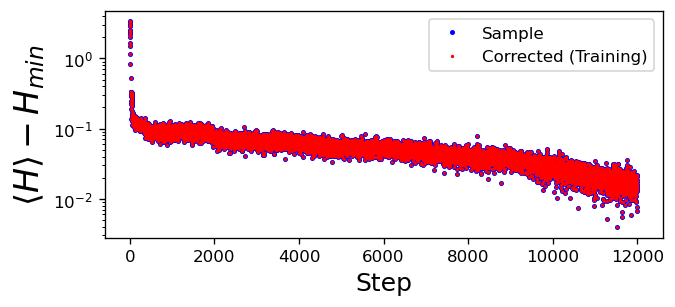

TIME: 1501s
Last Corrected -0.3641


In [14]:
run(4,0.0,noqueue=True)
run(6,0.0,noqueue=True)
run(8,0.0,noqueue=True)
run(12,0.0,noqueue=True)
run(16,0.0,noqueue=True)
show(4,4,0.0,noqueue=True)
show(6,6,0.0,noqueue=True)
show(8,8,0.0,noqueue=True)
show(12,12,0.0,noqueue=True)
show(16,16,0.0,noqueue=True)

# Comparing 16x16 results

16 1 16 256
512 32 16 256
512 32 16 256


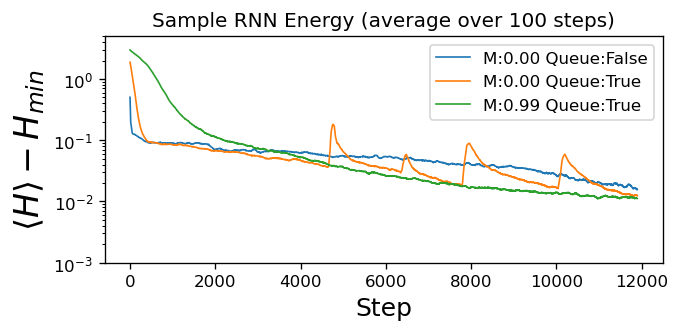

16 1 16 256
512 32 16 256
512 32 16 256


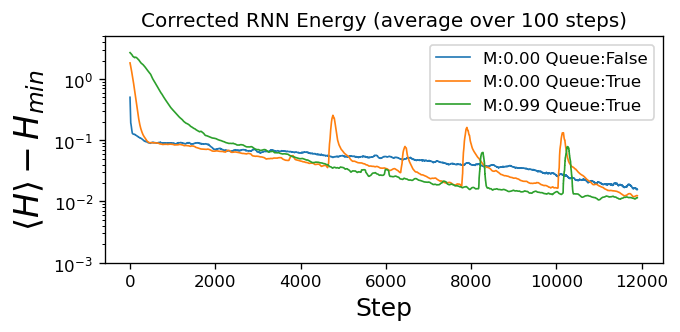

16 1 16 256
512 32 16 256
512 32 16 256


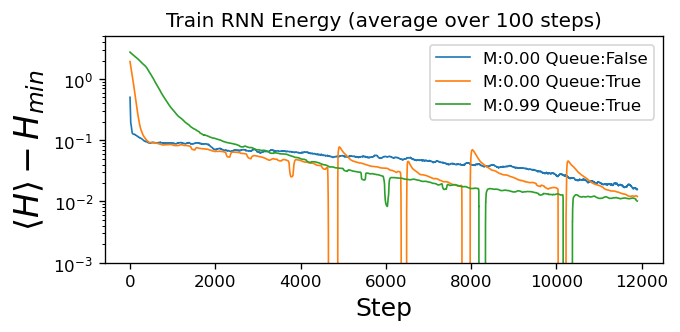

In [3]:
def plot_sample(Lx,Ly,M,mydir=None,noqueue=False,idx=5):
    
    exact_energy = {16:-0.4534,36:-0.4221,64:-0.40522,144:-0.38852,256:-0.38052,576:-0.36,1024:-0.34}[Lx*Ly]
    if type(mydir)==type(None):
        bsize=512
        BlockNum=(Lx*Ly)//8
        BbyL=bsize//BlockNum
        bsize=BbyL*BlockNum
        
        if noqueue:
            print(BbyL,1,BbyL,Lx*Ly)
            mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(Lx,Ly,M,BbyL,BbyL)
        else:
            print(bsize,BlockNum,BbyL,Lx*Ly)
            mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(Lx,Ly,M,bsize,BbyL)
    
    DEBUG = np.load(mydir+"/DEBUG.npy")
    
    
    avgs = np.array([np.mean(DEBUG[i:i+100,idx]) for i in range(DEBUG.shape[0]-100)])
    
    
    plt.plot(avgs/Lx/Ly-exact_energy,linewidth=1.0,markevery=5,
             label="M:%.2f Queue:%r"%(M,not noqueue))

    
    
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plot_sample(16,16,0.0,noqueue=True)
plot_sample(16,16,0.0)
plot_sample(16,16,0.99)
plt.yscale("log")
plt.ylim(1e-3,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.title("Sample RNN Energy (average over 100 steps)")
plt.show()

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plot_sample(16,16,0.0,noqueue=True,idx=3)
plot_sample(16,16,0.0,idx=3)
plot_sample(16,16,0.99,idx=3)
plt.yscale("log")
plt.ylim(1e-3,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.title("Corrected RNN Energy (average over 100 steps)")
plt.show()


fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plot_sample(16,16,0.0,noqueue=True,idx=1)
plot_sample(16,16,0.0,idx=1)
plot_sample(16,16,0.99,idx=1)
plt.yscale("log")
plt.ylim(1e-3,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.title("Train RNN Energy (average over 100 steps)")
plt.show()

In [35]:
run(24,0.99)
run(24,0.0)
run(24,0.0,noqueue=True)

7 1 7 576
504 72 7 576
504 72 7 576


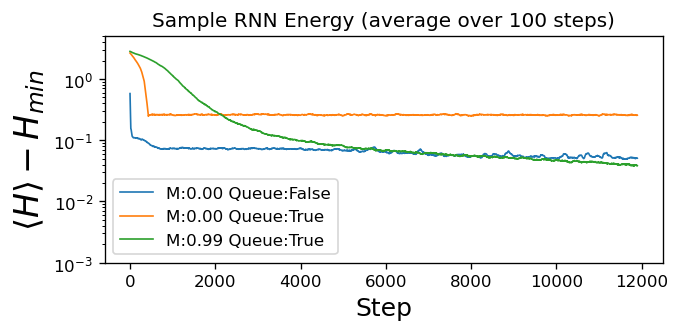

7 1 7 576
504 72 7 576
504 72 7 576


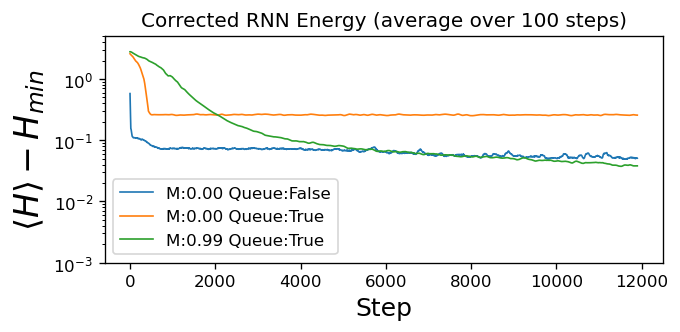

7 1 7 576
504 72 7 576
504 72 7 576


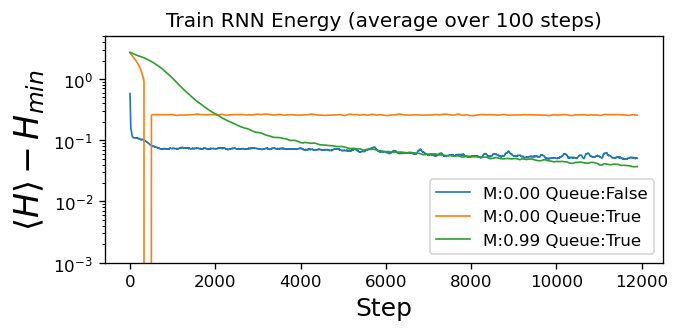

In [4]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plot_sample(24,24,0.0,noqueue=True)
plot_sample(24,24,0.0)
plot_sample(24,24,0.99)
plt.yscale("log")
plt.ylim(1e-3,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.title("Sample RNN Energy (average over 100 steps)")
plt.show()

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plot_sample(24,24,0.0,noqueue=True,idx=3)
plot_sample(24,24,0.0,idx=3)
plot_sample(24,24,0.99,idx=3)
plt.yscale("log")
plt.ylim(1e-3,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.title("Corrected RNN Energy (average over 100 steps)")
plt.show()


fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plot_sample(24,24,0.0,noqueue=True,idx=1)
plot_sample(24,24,0.0,idx=1)
plot_sample(24,24,0.99,idx=1)
plt.yscale("log")
plt.ylim(1e-3,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.title("Train RNN Energy (average over 100 steps)")
plt.show()

In [40]:
run(32,0.99)
run(32,0.0)
run(32,0.0,noqueue=True)

256 1 256 16
-0.4534569150209427
512 2 256 16
-0.4533902561664581
512 2 256 16
-0.45347503781318665


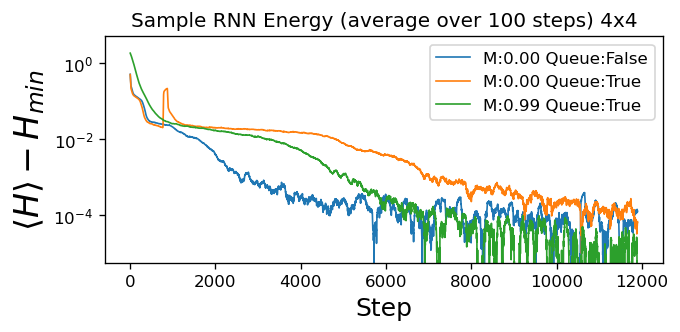

128 1 128 36
-0.422106388674842
512 4 128 36
-0.42218653413984514
512 4 128 36
-0.4222273617320591


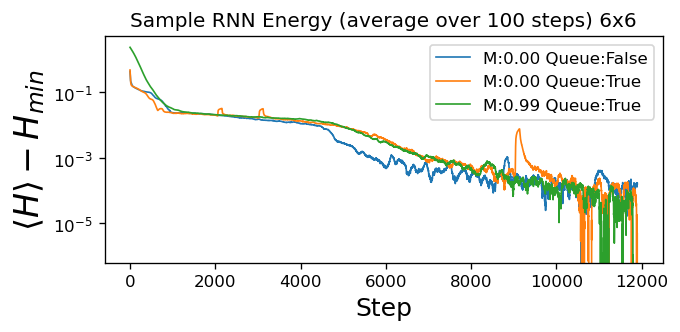

64 1 64 64
-0.40456113785505293
512 8 64 64
-0.3249058210849762
512 8 64 64
-0.40336380392313004


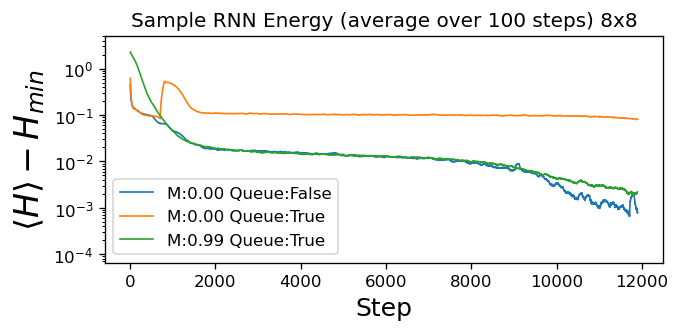

28 1 28 144
-0.37787084738413496
504 18 28 144
-0.37501972940233014
504 18 28 144
-0.37897185617023044


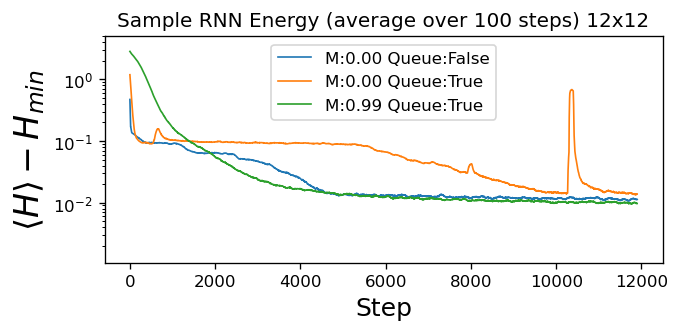

16 1 16 256
-0.36493719428777693
512 32 16 256
-0.36826002687215803
512 32 16 256
-0.36940828144550325


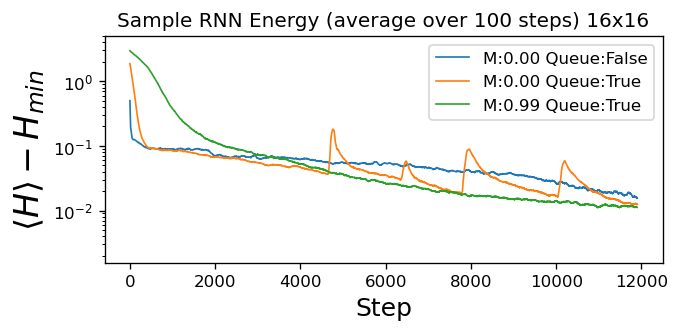

7 1 7 576
-0.31098560545179577
504 72 7 576
-0.11400383121437496
504 72 7 576
-0.3217812940809462


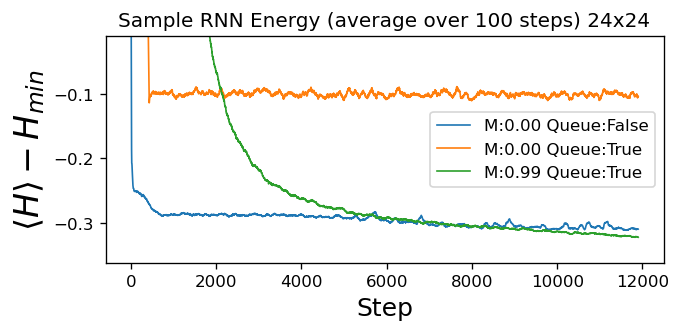

2 1 2 1024
-0.29086693078279496
512 256 2 1024
-0.2864133605360985
512 256 2 1024
-0.29154299318790433


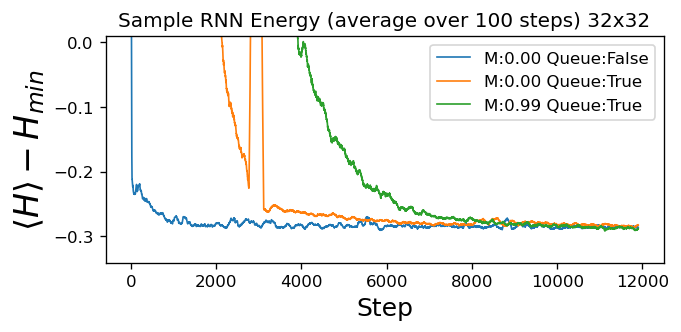

In [15]:
etable={16:-0.4534,36:-0.4221,64:-0.40522,144:-0.38852,256:-0.38052,576:-0,1024:-0}
def plot_sample(Lx,Ly,M,mydir=None,noqueue=False,idx=5):
    exact_energy = etable[Lx*Ly]
    bn = dict()
    for k in etable:bn[k]=k//8
    bn[1024]=256
    if type(mydir)==type(None):
        bsize=512
        BlockNum=bn[(Lx*Ly)]
        BbyL=bsize//BlockNum
        bsize=BbyL*BlockNum
        
        if noqueue:
            print(BbyL,1,BbyL,Lx*Ly)
            mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(Lx,Ly,M,BbyL,BbyL)
        else:
            print(bsize,BlockNum,BbyL,Lx*Ly)
            mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(Lx,Ly,M,bsize,BbyL)
    
    DEBUG = np.load(mydir+"/DEBUG.npy")
    
    
    avgs = np.array([np.mean(DEBUG[i:i+100,idx]) for i in range(DEBUG.shape[0]-100)])
    
    
    plt.plot(avgs/Lx/Ly-exact_energy,linewidth=1.0,markevery=5,
             label="M:%.2f Queue:%r"%(M,not noqueue))
    print(np.min(avgs/Lx/Ly))
    return np.min(avgs/Lx/Ly-exact_energy)
    
for x in [4,6,8,12,16,24,32]:
    fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
    ref=plot_sample(x,x,0.0,noqueue=True)
    plot_sample(x,x,0.0)
    plot_sample(x,x,0.99)
    if x<24:
        plt.yscale("log")  
        plt.ylim(abs(ref)/10,5)
    else:
        plt.ylim(ref-0.05,ref+0.3)
    plt.xlabel("Step",fontsize=15)
    plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
    plt.legend(loc="best")
    plt.title("Sample RNN Energy (average over 100 steps) %dx%d"%(x,x))
    plt.show()



In [ ]:
run(48,0.99)
run(48,0.0)
run(48,0.0,noqueue=True)